## GeometricErrors - Segment Shifting 

For KDD 2021 Major Revision

### Part 1: Loading Data

In [1]:
""" Environment Configuration """

# Source of input tensors. 
data_path = '/data/GeometricErrors/EM'

# Source of original rasters, shapefiles.
source_path ='/data/GeometricErrors/Scene01'

model_key = 'UNET'

# Path to save EM Test as folder
out_root_dir = '/data/GeometricErrors/tests/segment_shifting'

# Enables training with GPU
use_gpu = True
gpus = ['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3']

# Environment Seeds
seed = 2001


""" Point Shifting Annotator Configuration """

# number of points to generate on BOTH sides of each source point
pairs = 15

# Interval at which shifting vertices are sampled in meters
interval = 10

# Offset distance between each candidate segment as they are generated on either side of the source. (meters)
off_dist = 1.5

# Minimum Valid Proability threshold over map 
min_probability = 1e-06

# Weight consideration candidate0 line distance between candidate points
length_weight_value = 1e-3

# Buffer in meters to apply to candidates
weight_buffer = 2

""" UNET Config """

# Base learning rate to use in training. Reccomend 0.01
learning_rate = 0.1

epochs = 60

""" EM Iteration Config """

# Initial jump-start predicted class map path
seg_class_map_fp = None #'/data/pmap.tif'

# Number of EM iterations
em_target = 12

iou_buffer = 6

# Learning Rate Scheduler
import lib.K_Tools as kt 
lr_schedule = kt.Oscillate_LR

# Optionally Enable notes
prompt_notes = False


/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Std Imports
import os, sys, time, random, csv
from datetime import datetime as dt 

# Module Imports
import tensorflow as tf
import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as shp
from tensorflow.keras.optimizers import Adam

# Lib imports
import lib.Doc_Tools as doc
import lib.GeoTools as gt
import lib.Tiling as tile
import lib.K_Tools as kt
from lib.Annotators import *

""" Static Configuration """
# Batch size for training
batch_size = 32
# Early Stopping Patience
es_patience = 20
# Reduce Learning Rate on Plateau: Multiplier to reduce LR by upon plateau
rlop_factor = 0.5
# Adam Optimizer config
adam_epsilon = 1e-8
adam_decay = 1e-5


# Seed environment
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Prompt for notes on test
if prompt_notes:
    test_notes = input("Enter Notes for test: ")
else:
    test_notes = 'Notes have been disabled.'
    
### Create Folder for test documentation
test_idx, test_dir = doc.InitTest(out_root_dir,
                                  prompt=False,
                                  test_name='seg_test_',
                                  em_target=em_target,
                                  LR=learning_rate,
                                  notes=test_notes,
                                  pairs=pairs,
                                  interval=interval,
                                  off_distance=off_dist,
                                  min_p=min_probability,
                                  L=length_weight_value)

### Loading Source
train_raster = rio.open('{}/train_raster.tif'.format(source_path))
test_raster = rio.open('{}/test_raster.tif'.format(source_path))
template_raster = rio.open('{}/template_map.tif'.format(source_path))

gt_labels = gpd.read_file('{}/GroundTruth.shp'.format(source_path))
imp_labels = gpd.read_file('{}/imperfectLines.shp'.format(source_path))

### Loading Tensors
X_train = np.load('{}/X_train.npy'.format(data_path))
Y_train = np.load('{}/Y_train.npy'.format(data_path))

X_val = np.load('{}/X_val.npy'.format(data_path))
Y_val = np.load('{}/Y_val.npy'.format(data_path))

X_test = np.load('{}/X_test.npy'.format(data_path))
Y_test = np.load('{}/Y_test.npy'.format(data_path))


### Loading tile offsets
train_offsets_fp = '{}/train_offsets.csv'.format(data_path)
val_offsets_fp = '{}/val_offsets.csv'.format(data_path)
print("Successfully loaded tensors.")

# Convert All CRS's
imp_labels = imp_labels.to_crs(train_raster.crs)
gt_labels = gt_labels.to_crs(imp_labels.crs)
source_annotation = imp_labels

### Evaluate original Shapefile Precision
source_iou = gt.gdf_iou(gt_labels, imp_labels, iou_buffer)
prev_iou = source_iou

### Create A distributed training strategy for GPU training
if use_gpu:
    mirror_strategy = tf.distribute.MirroredStrategy(devices=gpus)

Successfully loaded tensors.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


### Part 1: Baseline Model Training and Evaluation


Preparing UNET model...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0'

Epoch 28/60
88/88 [==============================] - 11s 130ms/step - dice_coef: 0.3123 - loss: -0.3129 - accuracy: 0.9310 - f1_score: 0.3123 - val_dice_coef: 0.1795 - val_loss: -0.1795 - val_accuracy: 0.9308 - val_f1_score: 0.1787 - lr: 0.0125
Epoch 29/60
88/88 [==============================] - 11s 130ms/step - dice_coef: 0.3175 - loss: -0.3184 - accuracy: 0.9314 - f1_score: 0.3174 - val_dice_coef: 0.1853 - val_loss: -0.1853 - val_accuracy: 0.9283 - val_f1_score: 0.1848 - lr: 0.0125
Epoch 30/60
88/88 [==============================] - 11s 130ms/step - dice_coef: 0.3176 - loss: -0.3194 - accuracy: 0.9311 - f1_score: 0.3176 - val_dice_coef: 0.1995 - val_loss: -0.1995 - val_accuracy: 0.9291 - val_f1_score: 0.1991 - lr: 0.0125
Epoch 31/60
88/88 [==============================] - 11s 130ms/step - dice_coef: 0.3224 - loss: -0.3236 - accuracy: 0.9318 - f1_score: 0.3224 - val_dice_coef: 0.2011 - val_loss: -0.2011 - val_accuracy: 0.9313 - val_f1_score: 0.2000 - lr: 0.0125
Epoch 32/60
88/88 [=

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Baseline Preformance:
Training Report 00
 - F1_Score: 36.319
 - Dice_Score: 36.318
 - False_Positives: 150735900.000
 - False_Negatives: 716204800.000
 - Precision: 30.956
 - Recall: 43.930
 - Keras_Precision: 47.194
 - Keras_Recall: 15.832
Validation Report 00
 - F1_Score: 33.263
 - Dice_Score: 33.266
 - False_Positives: 8283400.000
 - False_Negatives: 44712200.000
 - Precision: 30.050
 - Recall: 37.244
 - Keras_Precision: 45.557
 - Keras_Recall: 13.422
Testing Report 00
 - F1_Score: 42.798
 - Dice_Score: 42.795
 - False_Positives: 12870000.000
 - False_Negatives: 6482500.000
 - Precision: 36.001
 - Recall: 52.759
 - Keras_Precision: 36.001
 - Keras_Recall: 52.759
 - Confusion Matrix: [[9769277  128700]
 [  64825   72398]]



Wed at 11:37:43PM


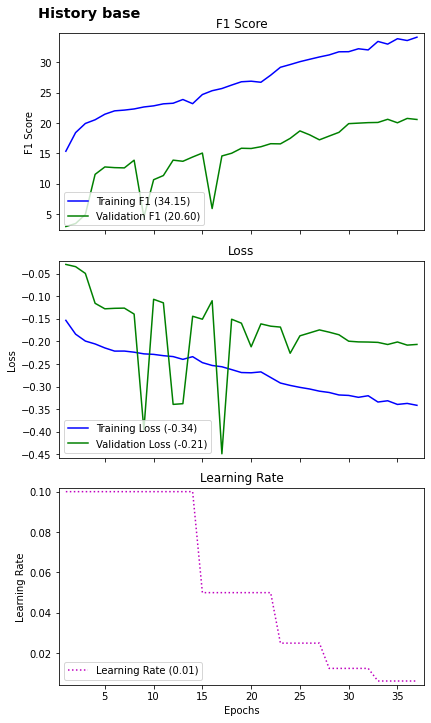

In [3]:
### Baseline Model Training

# Get timer for baseline training
base_start = time.perf_counter()

# Prepare Baseline Folder
base_folder = os.path.join(test_dir, 'baseline')
if not os.path.exists(base_folder): os.mkdir(base_folder)

# Prepare tensorboard folder
base_tb_dir = os.path.join(base_folder, 'tensorboard')
    
# Prepare Callbacks, including weight output
base_callbacks = kt.SetCallbacks(weights_out=base_folder+'/BaselineWeights.h5', es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path=base_tb_dir)
metrics = [kt.dice_coef,'accuracy', kt.f1_score]
    
if use_gpu:
    with mirror_strategy.scope():
        # Select and Build Model
        model = kt.Get_Model(model_key)
        model.compile(optimizer=Adam(lr=learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss = kt.dice_coef_loss, metrics=metrics)

        # Train Model
        baseline_results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=60, callbacks=base_callbacks)
else:
    # Select and Build Model
    model = kt.Get_Model(model_key)
    model.compile(optimizer=Adam(lr=learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss = kt.dice_coef_loss, metrics=metrics)

    # Train Model
    baseline_results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=32, epochs= epochs, callbacks=base_callbacks)

# Save History plot and csv
doc.plot_history(baseline_results, test_dir=base_folder, config_idx='base')

epochs_used = len(baseline_results.history['accuracy'])

    
""" Evaluate Baseline Model Preformance """
print("Baseline Preformance:")
train_rpt = kt.ModelReport(X_train, Y_train, model, 'Training')
val_rpt = kt.ModelReport(X_val, Y_val, model, 'Validation')
test_rpt = kt.ModelReport(X_test, Y_test, model, 'Testing')

print(dt.now().strftime('\n\n%a at %I:%M:%S%p'))


### Part 2: EM Iteration

`Warning`: By proceeding, the EM Iteration will use the model configured above with the parameters already set. Tune the baseline model above as many times as needed before proceeding.

#### Section 1: Configure EM Test with Annotator

In [4]:
# Prepare annotator
annotator = Segment_Annotator(pairs=pairs,                   # Number of pairs to be linearly generated on either side of the source point 
                             off_dist=off_dist,             # Interval distance that each new pair is generated
                             interval=interval,             # Inteval at which new candidate groups are generated
                             min_p=min_probability,         # Minimum valid probability from class map
                             L=length_weight_value,         # Weight for line distance
                             weight_buffer=weight_buffer,   # Buffer to apply to candidates when weighting
                             normalize_full=False,          # Optionally normalize by K^2 instead of K
                             )

    
# Prepare performance storage
em_dict = {
    'Name': ['Base'],
    'Test_Data': [test_rpt],
    'Train_Data': [train_rpt],
    'Val_Data': [val_rpt],
    'Line_IoU': [np.round((source_iou*100), 2)],
    'Epochs': [epochs_used],
    'LR': [learning_rate],
    'Training_Time': ['{:.3f} s'.format(time.perf_counter() - base_start)],
    'Update_Time': ['NA'],
}

# Prepare EM iterator index.
EM_iterator = 0

# Prepare storage for top F1 and IoU
top_f1, top_f1_idx = 0, 0
top_iou, top_iou_idx = 0, 0


#### Run EM Iteration

Beginning Iteration, Target steps: 17
Current Step: 16

EM Step 16 begun.
Thu at 02:52:07PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 16)
Thu at 02:52:48PM

Created New Annotation. (Step 16)
Thu at 02:55:13PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 16)
Thu at 02:55:19PM

New Learning Rate: 0.050000. (Step 16)
Preparing UNET model...
UNET model built successfully.

Training model...
Completed model Training. (Step 16)
Thu at 03:07:30PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 17
 - F1_Score: 54.989
 - Dice_Score: 54.984
 - False_Positives: 2619600.000
 - False_Negatives: 7525300.000
 - Precision: 70.288
 - Recall: 45.160
 - Keras_Precision: 70.288
 - Keras_Recall: 45.160
 - Confusion Matrix: [[9871781   26196]
 [  75253   61970]]

Training Report 17
 - F1_Score: 67.745
 - Dice_Score: 67.744
 - False_Positives: 31851200.000
 - False_Negatives: 736890700.000
 - Precision: 75.569
 - Recall: 61.390
 - Keras_Precision: 81.586
 - Keras_Recall: 16.073
Validation Report 17
 - F1_Score: 51.329
 - Dice_Score: 51.318
 - False_Positives: 2152600.000
 - False_Negatives: 46263500.000
 - Precision: 63.995
 - Recall: 42.848
 - Keras_Precision: 74.327
 - Keras_Recall: 11.872

EM Step (16) Complete on Thu at 03:07:56PM
- Annotation IoU:     26.75
	- Source Improvement: -1798.25
	- Step Improvement:   -0.28

------ Times ---------------------
- Class Map Generation: 40.993 s
- Annotation Update:    130.947 s
- Model Training:       730.869 s
- Model Evaluation:

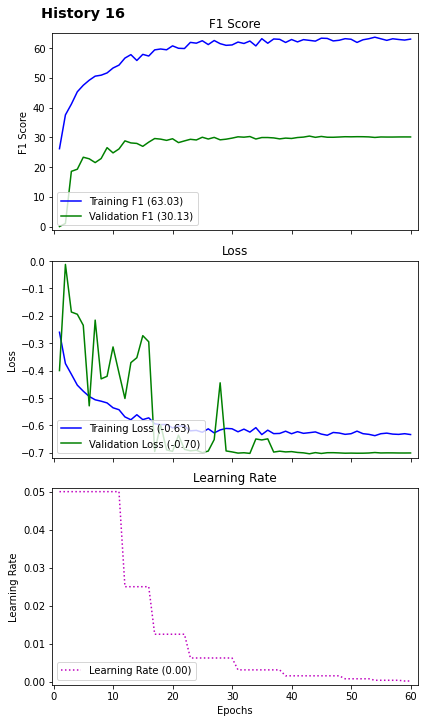

In [14]:
print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if EM_iterator == 0:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        train_pmap_fp = os.path.join(emfolder, 'train_pmap_baseline.tif')
        test_pmap_fp = os.path.join(emfolder, 'test_pmap_baseline.tif')
        train_pmap = kt.Get_Pmap(train_raster, model, train_pmap_fp)
        kt.Get_Pmap(test_raster, model, test_pmap_fp)
        if seg_class_map_fp:
            predicted_class_map = rio.open(seg_class_map_fp)
        else:
            predicted_class_map = train_pmap
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        train_pmap_fp = os.path.join(emfolder, 'train_pmap_{:02}.tif'.format(EM_iterator))
        test_pmap_fp = os.path.join(emfolder, 'test_pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, train_pmap_fp)
        kt.Get_Pmap(test_raster, model, test_pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf(gdf=source_annotation, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=2, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1


### Create Plots

/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


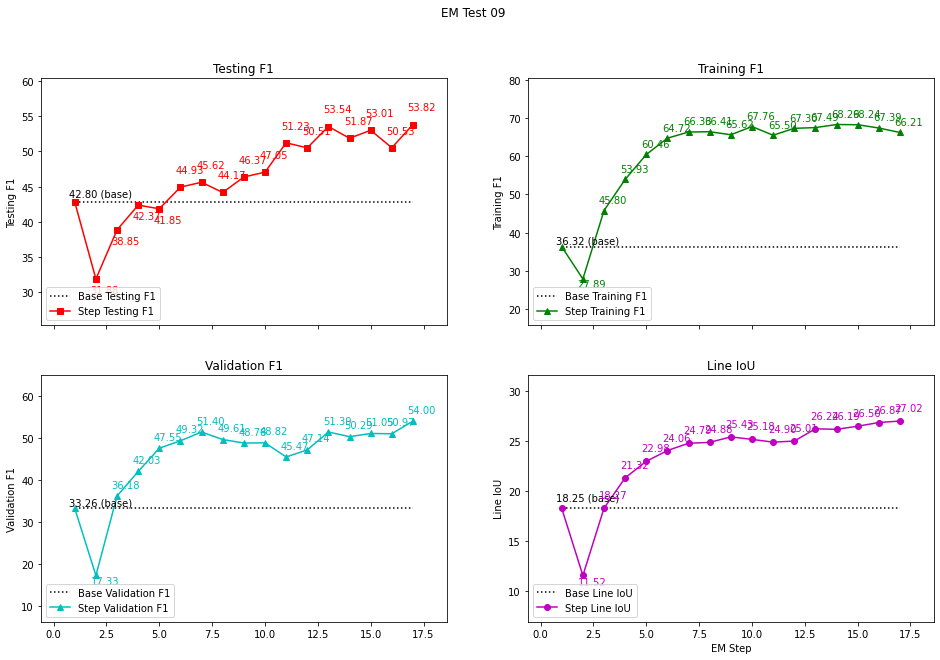

In [13]:
# Clean data for easy indexing

## Converts each of the report lists into a dict of lists for each value
model_dict = {'Test_Data': {}, 'Train_Data': {}, 'Val_Data': {}}
for em_key in model_dict.keys():
    for report in em_dict[em_key]:
        for rpt_key, rpt_value in [(key, item) for key, item in report.items()]:
            if rpt_key not in model_dict[em_key].keys():
                model_dict[em_key].update({rpt_key: np.array([rpt_value])})
            else:
                model_dict[em_key][rpt_key] = np.append(model_dict[em_key][rpt_key], report[rpt_key])


# Create Figure for Plots
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(16,10))

## Plot Testing F1
doc.plot_axis(ax=axs[0,0], 
              data=model_dict['Test_Data']['F1_Score']*100, 
              name='Testing F1', 
              color_char='r', 
              symbol_char='s', 
              y_off=2,
              label_delta=False)

## Plot Training F1
doc.plot_axis(ax=axs[0,1], 
              data=model_dict['Train_Data']['F1_Score']*100, 
              name='Training F1', 
              color_char='g', 
              symbol_char='^', 
              y_off=2,
              label_delta=False)

## Plot Validation F1
doc.plot_axis(ax=axs[1,0], 
              data=model_dict['Val_Data']['F1_Score']*100, 
              name='Validation F1', 
              color_char='c', 
              symbol_char='^', 
              y_off=2,
              label_delta=False)

## Plot Annotation IoU
doc.plot_axis(ax=axs[1,1], 
              data=em_dict['Line_IoU'], 
              name='Line IoU', 
              color_char='m', 
              x_label='EM Step',
              label_delta=False)
    
## Title and show, and save figure
fig.suptitle("EM Test {:02}".format(test_idx))
fig_path = os.path.join(test_dir, 'test_{:02}_plot.png'.format(test_idx))
fig.savefig(fig_path)
fig.show()


### Save to Markdown

Saves:
- Annotator Config
- Model Config
- EM preformance table
- Model preformance table

In [7]:
### Write test data to markdown
markdown_fp = os.path.join(test_dir, 'em_test_info_{:02}.md'.format(test_idx))
md = open(markdown_fp, 'w+')

# Header / Notes
md.write("# EM Test {:02}\n\n".format(test_idx))

if (len(test_notes) > 0):
    md.write("### Notes: \n")
    md.write(test_notes)

md.write(dt.now().strftime('\n%a at %I:%M:%S%p'))
    
md.write("\n\n---\n\n")

# prepare peak values
top_f1 = np.round((top_f1*100), 3)
source_f1 = np.round((em_dict['Test_Data'][0]['F1_Score']*100), 3)
source_iou = np.round(source_iou*100, 2)

# Note at top the peak values 
md.write("### Top Values:\n\n")
md.write(" - Testing F1 Score: **{:.2f}** (`{:+.2f}`) - Step {:02}\n".format(top_f1, (top_f1-source_f1), top_f1_idx))
md.write(" - Annotation IoU: **{:.2f}** (`{:+.2f}`) - Step {:02}\n\n\n".format(top_iou, (top_iou-source_iou), top_iou_idx))



# Test Configuration Section
md.write("## **Test Config**\n\n")

md.write("Random Seed: {}".format(seed))

md.write("### Annotator:\n")
for key, item in annotator.__dict__.items():
    
    # Skip gross keys
    if key in ['verbosity', 'crop_window', 'class_map', 'kwargs_key', 'crs']:
        continue
    
    # Write key and item
    md.write("- `{}`: {}\n".format(key, item))
        
md.write("\n\n")

md.write("### Model:\n")
md.write("- **Training**:\n")
md.write("  - `Batch Size`: {}\n".format(batch_size))
md.write("  - `Learning Rate`: {}\n".format(learning_rate))
md.write("  - `Epochs`: {}\n".format(epochs))
md.write("- **Callbacks**:\n")
md.write("  - `ES Patience`: {}\n".format(es_patience))
md.write("  - `RLOP Factor`: {}\n".format(rlop_factor))
md.write("  - `Adam Epsilon`: {}\n".format(adam_epsilon))
md.write("  - `Adam Decay`: {}\n".format(adam_decay))

md.write("\n\n")

md.write("### Other:\n")
md.write("- EM Steps: {}\n".format(em_target))
md.write("- ClassMap: '{}'\n".format(seg_class_map_fp))


md.write("\n---\n\n")


# Results Section

md.write("## **Results**:\n\n")

md.write("### EM Iteration:\n\n")

md.write("Step | Anno IoU | F1 | Epochs | LR | Train | Update\n")
md.write("---- | -------- | -- | ------ | -- | ----- | ------\n")
for idx in range(em_target):
    if idx == 0:
        md.write("{} | {} | {} | {} | {} | {} | {}\n".format(em_dict['Name'][idx], em_dict['Line_IoU'][idx], em_dict['Test_Data'][idx]['F1_Score'], em_dict['Epochs'][idx], em_dict['LR'][idx], em_dict['Training_Time'][idx], em_dict['Update_Time'][idx]))
    else:
        md.write("{} | {} (`{:+.2f}`) | {} | {} | {} | {} | {}\n".format(em_dict['Name'][idx], em_dict['Line_IoU'][idx], (em_dict['Line_IoU'][idx] - em_dict['Line_IoU'][0]), em_dict['Test_Data'][idx]['F1_Score'], em_dict['Epochs'][idx], em_dict['LR'][idx], em_dict['Training_Time'][idx], em_dict['Update_Time'][idx]))

md.write("\n\n</br>\n\n")
    
md.write("### Model Performance:\n\n")
md.write("Step | Test F1 | Test (FP, FN) | Train F1 | Train (FP, FN) | Val F1 | Val (FP, FN) | LR \n")
md.write("---- | ------- | ------------- | -------- | -------------- | ------ | ------------ | -- \n")
for idx in range(em_target):
    # Create a string to hold this row's data
    row_string = "{} | ".format(em_dict['Name'][idx])
    
    # Iterate over F1 types
    for key in ['Test_Data', 'Train_Data', 'Val_Data']:
        
        if idx == 0:
            row_string += "{:.2f} | ({:.2e}, {:.2e}) | ".format(em_dict[key][idx]['F1_Score']*100, em_dict[key][idx]['False_Positives'], em_dict[key][idx]['False_Negatives'])
        else:
            row_string += "{:.2f} (`{:+.2f}`) | ({:.2e}, {:.2e}) | ".format(em_dict[key][idx]['F1_Score']*100, (em_dict[key][idx]['F1_Score']*100 - em_dict[key][0]['F1_Score']*100), em_dict[key][idx]['False_Positives'], em_dict[key][idx]['False_Negatives'])
      
    # After all sets have been added, append learning rate and newline
    row_string += "{}\n".format(em_dict['LR'][idx])
    md.write(row_string)


# Close Markdown
md.close()

print("Config and results written to markdown.")
print("Location:", markdown_fp)

Config and results written to markdown.
Location: /data/GeometricErrors/tests/segment_shifting/seg_test_09/em_test_info_09.md
